In [1]:
import pandas as pd
import numpy as np

In [2]:
# 채용 정보별 columns를 하나의 문자열로 묶어서 하나의 column에 저장

df = pd.read_csv('../crawling/data_df.csv')
columns = df.columns

def combine_func(row):
    return "// ".join([str(row[col]) for col in columns])

df["combined"] = df.apply(combine_func, axis=1)
embeddings = pd.DataFrame(df["combined"])
embeddings.columns = ['data']

In [3]:
# 토큰화

import tiktoken

tokenizer = tiktoken.get_encoding("cl100k_base")
embeddings['n_tokens'] = embeddings.data.apply(lambda x: len(tokenizer.encode(x)))

<Axes: >

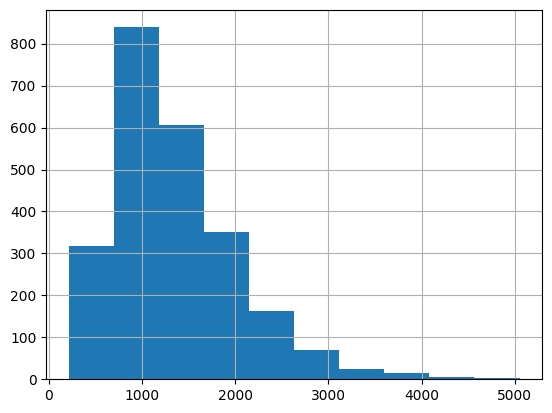

In [12]:
embeddings.n_tokens.hist()

In [13]:
# max_tokens = 500
# def split_into_many(text, max_tokens = max_tokens):

#     # 일단 문장으로 쪼개기
#     sentences = text.split('. ')

#     # 문장마다 몇 토큰 들어가는지 세어 주기.
#     n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
#     chunks = []
#     tokens_so_far = 0
#     chunk = []


#     for sentence, token in zip(sentences, n_tokens):

#         # 문장의 토큰 수와 현재까지의 토큰 수의 합이 최대 토큰 수를 초과하면, 해당 청크를 청크 목록에 추가하고 청크 및 현재까지의 토큰 수를 초기화한다.
#         if tokens_so_far + token > max_tokens:
#             chunks.append(". ".join(chunk) + ".")
#             chunk = []
#             tokens_so_far = 0


#         if token > max_tokens:
#             continue

#         chunk.append(sentence)
#         tokens_so_far += token + 1

#     if chunk:
#         chunks.append(". ".join(chunk) + ".")

#     return chunks

In [3]:
import os
from openai import OpenAI
import openai
client = OpenAI()
openai.api_key  = os.getenv('OPENAI_API_KEY')

In [4]:
# embedding 값 추가

embeddings['embeddings'] = embeddings.data.apply(lambda x: client.embeddings.create(input=x, model='text-embedding-ada-002').data[0].embedding)
embeddings.to_csv('embeddings.csv', encoding='utf-8', index=False)
embeddings.head()

,data,embeddings
0,"21310// 개발 팀장// 한국해양기상기술// 한국 해양 기상 기술은 해양,기상환...","[0.006333442870527506, -0.0012947228970006108,..."
1,21110// [Moloco] Senior Data Scientist// 몰로코//...,"[-0.01246270164847374, -0.012198425829410553, ..."
2,"20853// AI 엔지니어// 피매치// ""고객이 자기주도적으로 웰니스를 실현하는...","[-0.006364488508552313, -0.011195365339517593,..."
3,21851// JAVA 백엔드 개발자(차장급)// 아파트아이// 아파트아이란?\n ...,"[0.0037601562216877937, -0.01637846976518631, ..."
4,22041// [5년 이상 리더급] 풀스택 소프트웨어 엔지니어// 다이얼로그디자인에...,"[-0.009879649616777897, -0.016573673114180565,..."


In [15]:
# 코사인 유사도를 구해서 유사한 문맥 찾기

from scipy.spatial.distance import cosine

def create_context(
    question, df, max_len=1800
):
    """
    데이터 프레임으로부터 가장 유사한 문맥을 찾아서 질문에 대한 문맥을 만든다.
    """

    # 질문으로부터 임베딩을 만든다.
    q_embeddings = client.embeddings.create(input=question, model='text-embedding-3-small').data[0].embedding

    # 임베딩으로부터 거리를 계산한다.
    df["distances"] = df["embeddings"].apply(lambda x: cosine(q_embeddings, x))
    returns = []
    cur_len = 0
    # 거리순으로 정렬하고, 문맥이 너무 길어지기 전까지만 텍스트를 문맥에 추가한다.
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        

        # 현재 토큰 수에 텍스트 길이를 더한다.
        cur_len += row['n_tokens'] + 4
        
        # 문맥이 너무 길어지면, break
        if cur_len > max_len:
            break
        

        # 아니면, 문맥에 추가한다.
        returns.append(row["data"])

    # Return the context
    return "\n\n###\n\n".join(returns)


# 이 함수가 하는 일 다시 정리해보자.
# 1. 질문이 들어오면 질문을 임베딩한다. 즉, 숫자 표현으로 바꿔준다.
# 2. 모든 문장들의 임베딩과 질문의 임베딩 사이의 거리를 계산한다.
# 3. 문맥이 너무 길어지면 안되니까, 가장 거리가 가까운 문장부터 차례대로 문맥에 추가한다.
# 4. 문맥을 반환한다.

In [16]:
# gpt-3.5-turbo를 활용한 QA 함수

def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    debug=False,
):
    """
    데이터 프레임 텍스트에서 가장 유사한 문맥을 기반으로 질문에 답한다.
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
    )

    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\n"},
                {"role": "user", "content": f"Context: {context}\n\n---\n\n Question: {question}"}
            ],
            temperature=0,
        )
        return response.choices[0].message.content
    except Exception as e:
        print("Error occurred:", e)
        return ""

In [17]:
answer_question(embeddings, question="What day is it?", debug=False)

"I don't know."

In [19]:
answer_question(embeddings, question="python을 할 줄 알면, 어떤 회사에서 일을 할 수 있어?", debug=False)

'뉴로다임에서 일을 할 수 있습니다.'

In [20]:
answer_question(embeddings, question="뉴로다임은 어떤 회사야?", debug=False)

'뉴로다임은 2016년에 설립된 전문 인공지능 연구 개발 회사로, 글로벌 시장을 겨냥한 작지만 강한 AI 연구 기업입니다.'

In [23]:
answer_question(embeddings, question="그릿스탠다드는 어떤 프로그래밍 언어를 필요로 하는 회사야?", debug=False)

'그릿스탠다드는 TypeScript를 필요로 하는 회사입니다.'

In [25]:
answer_question(embeddings, question="서버/백엔드 개발자로 일하려면 어떤 프로그래밍 언어를 알아야할까?", debug=False)

'To work as a server/backend developer, you should know Java and JavaScript (Node.js) programming languages.'

In [26]:
answer_question(embeddings, question="AI 개발자로 일하려면 어떤 프로그래밍 언어를 알아야할까?", debug=False)

'Based on the context, AI 개발자로 일하려면 Python 혹은 Java 등의 프로그래밍 언어를 알아야 합니다.'

In [29]:
answer_question(embeddings, question="뉴로다임은 어떤 복리 후생을 제공해?", debug=False)

'뉴로다임은 자유 복장 및 자유로운 연차 사용 가능, 휴게실 제공, 인센티브제, 우수사원포상제, 스톱옵션, 경조사 지원 등의 복리 후생을 제공합니다.'

In [30]:
answer_question(embeddings, question="python을 할 줄 알면, 어떤 직무로 일을 할 수 있어?", debug=False)

'Based on the context, if you know Python, you can work as a "파이썬 프로그램 개발자" (Python Program Developer) at "뉴로다임" (Neurodime) or as a "기술지원" (Technical Support) at "에스엔에이" (SNA).'